In [7]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sparseDynamicRecon import load
from ipywidgets import Output, GridspecLayout
from IPython.display import display, Video, HTML
%matplotlib notebook

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 12, 20, 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def figure(name, *args, figsize=(9.5,6), **kwargs):
    plt.close(name)
    f = plt.figure(name, *args, figsize=figsize, **kwargs)
    return f
def show(): plt.tight_layout()

In [42]:
basedir = Path('results')/'problem_3'
time_unit = 1, 'seconds' # count in units of seconds

def getPath(d,string):
    files = tuple({str(d/f.stem) for f in d.iterdir() if f.name.startswith(string)})
    if len(files)<=1:
        return files[0]
    else:
        return {Path(f).stem:f for f in files}


fname, LOAD = {},{}
fname['general'] = {s:getPath(basedir/'general', s) for s in ('Bredies','randpaths','uniformpaths')}
# fname['compare'] = {s:getPath(basedir/'compare', s) for s in ('Bredies','randpaths','uniformpaths')}
fname['noise'] = {'params_%d'%i:{s:getPath(basedir/'noise'/('params_%d'%i), s) for s in ('Bredies','randpaths','uniformpaths')}
                     for i in range(4)}
def load_dict(f):
    d = {}
    for k,v in f.items():
        if type(v) is str:
            d[k] = load(v)
        else:
            d[k] = load_dict(v)
    return d
LOAD = load_dict(fname)
            
k2s = {'Bredies':'Bredies et. al.', 'randpaths':'Random mesh', 'uniformpaths':'Uniform mesh'}

In [44]:
def plotConvergence(name, d, ncol, bottom, figsize=(9.5,5), k2s=k2s, ZERO=1e-7):
    F = figure(name, figsize=figsize); # F.suptitle(name)
#     params = ('Energy','E'), ('Discrete gap', 'gap'), ('Number of curves', 'dof')
    params = ('Energy','E'), ('Number of curves', 'dof')

    for i, p in enumerate(params):
        ax = plt.subplot(1,len(params),i+1); ax.set_title(p[0])
        tmp = {}
        for k,v in d.items():
            j = list(v[1].extras()).index(p[1])
            tmp[k] = v[1].T/time_unit[0], v[1].E[:,j]

        if p[1] != 'dof':
            E = min(v[1].min() for v in tmp.values()), max(v[1].max() for v in tmp.values())
        else:
            E = 0, min(v[1][v[1]>0].min() for v in tmp.values())
        minT = .1*min(v[0][1] for v in tmp.values())
            
        for j,k in enumerate(k2s): # hopefully this preserves order...
            if k in tmp:
                v = tmp[k]
            else:
                continue
            ax.plot(np.maximum(v[0],minT),(v[1]-E[0])/(E[1]-E[0]), 'x-', label=(None if i>0 else k2s[k]))

        ax.set_xlabel('time(%s)'%time_unit[1]); ax.set_xscale('log'); ax.set_xlim(1.1*minT,None)
        if p[1] != 'dof':
            ax.set_yscale('log'); ax.set_ylim(ZERO,3)
        else:
            ax.set_ylim(0,None); ax.set_yticks([int(t) for t in ax.get_yticks() if int(t)==t])
        plt.grid(True, 'major')

    if None in (ncol, bottom):
        show()
    else:
        F.legend(loc='lower center', ncol=ncol)
        show()
        F.subplots_adjust(bottom=bottom)
    return F

# Analysis of default reconstructions
## Plots of final reconstructions

<IPython.core.display.Javascript object>


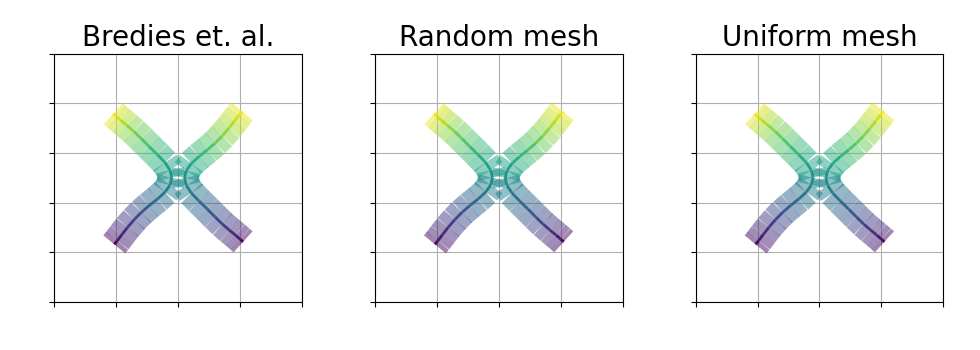

In [18]:
F = figure('Standard reconstructions', figsize=(9.8,3.5));#  F.suptitle('Reconstruction')
for i,(k,v) in enumerate(LOAD['general'].items()):
    ax = plt.subplot(1,3,i+1)
    v[0].plot(ax=ax, width=40, minwidth=1, decimals=8, alpha=.5)
    v[0].plot(ax=ax, width=1, minwidth=2, decimals=8, alpha=1)
    ax.set_title(k2s[k]); ax.set_aspect('equal')
    plt.xticks(color='w'); plt.yticks(color='w'); plt.grid(True, 'major')
show()
F.savefig(Path('.')/'..'/'figures'/'problem3_reconstruction.pdf')

In [ ]:
display(HTML('<h2><b>Videos of reconstructions</b></h2> Shows if uncommented.'))
# for k,v in fname['general'].items():
#     display(HTML('<h1 style="text-align:center"> %s Reconstruction</h1>'%k2s[k]))
#     display(Video(v+'.mp4', embed=False, width=800, html_attributes='loop autoplay controls'))

## Plots of convergence

<IPython.core.display.Javascript object>


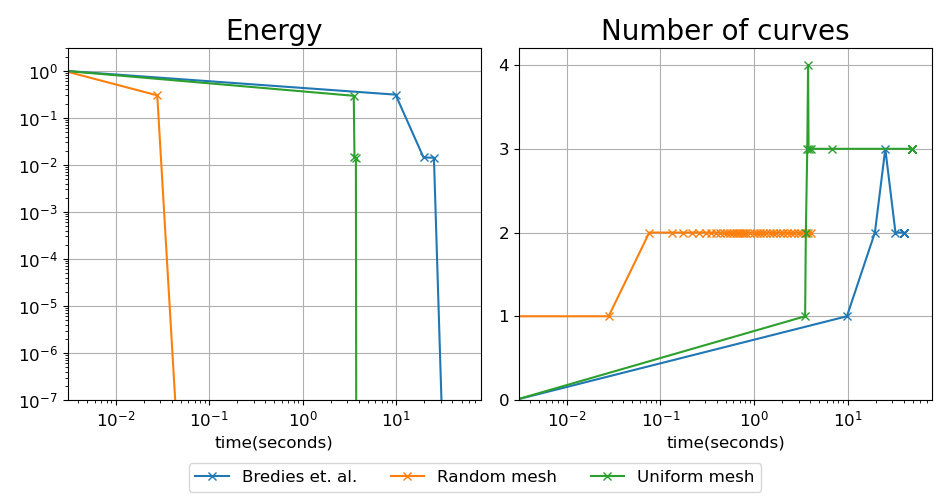

In [45]:
F = plotConvergence('Standard reconstruction convergence', d=LOAD['general'], ncol=3, bottom=0.2)
F.savefig(Path('.')/'..'/'figures'/'problem3_convergence.pdf')

# Comparing different variations of the Bredies code

In [19]:
F = plotConvergence('Bredies variants convergence', d=LOAD['compare']['Bredies'], ncol=2, bottom=0.18,
                   k2s={'Bredies':'Standard', 'Bredies_nosplitting': 'Without splitting'})

KeyError: 'compare'

# Comparing different variations of the Random Mesh code
The variations are parametrised $(i,j)$ where:
- $i$ is the number of new curves added at each iteration 
- $j$ is the 'mesh-size' at each iteration, i.e. $ j^2 $ random 2D points are sampled at every iteration and time-point

Note that if $i > j^2$, then the $i$ new curves are initialised uniformly randomly.

In [ ]:
F = plotConvergence('Random mesh variants convergence', d=LOAD['compare']['randpaths'], ncol=3, bottom=0.25,
                   k2s={'randpaths_%d_%d'%(i,j):str((i,j)) for i in (1,5,25) for j in (1,5,25)})

# Comparing different variations of the Uniform Mesh code
The variations are parametrised $(i,j)$ where:
- $i$ is the number of new curves added at each iteration 
- $j$ is the maximum number of refinements, i.e. maximum mesh-size is $ 2^j\times2^j $

In [ ]:
F = plotConvergence('Uniform mesh variants convergence', d=LOAD['compare']['uniformpaths'], ncol=3, bottom=0.25,
                   k2s={'uniformpaths_%d_%d'%(i,j):str((i,j)) for i in (1,5,25) for j in (8,7,6)})

# Convergence with different noise levels

In [ ]:
F = plotConvergence('No noise example', d=LOAD['noise']['params_0'], ncol=3, bottom=0.18)
F = plotConvergence('Low noise example', d=LOAD['noise']['params_1'], ncol=3, bottom=0.18)
F = plotConvergence('High noise example', d=LOAD['noise']['params_2'], ncol=3, bottom=0.18)